# Hydrogel-Cell Interaction

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations
sys.path.append('../module/')
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

In [2]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

import math, random

def fibonacci_sphere(samples=1,randomize=True):
    rnd = 1.
    if randomize:
        rnd = random.random() * samples

    points = []
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment

        x = math.cos(phi) * r
        z = math.sin(phi) * r

        points.append([x,y,z])

    return points

n_data = 7800
Vp = np.stack(fibonacci_sphere(samples=n_data), axis=0)
Vr, Vtheta, Vphi = CartCoord_to_SphCoord(Vp[:,0],Vp[:,1],Vp[:,2])

r0 = 5.26
Vr = Vr * r0 + np.random.normal(loc=0.0, scale=0.05, size=n_data)
print(Vr)
Vp[:,0],Vp[:,1],Vp[:,2] = SphCoord_to_CartCoord(Vr, Vtheta, Vphi)

Tfv = np.zeros(n_data, dtype=np.bool)
print('Traction free boundary of v:', Tfv.shape)

[5.31479086 5.38514257 5.27060576 ... 5.25418784 5.30071297 5.23749484]
Traction free boundary of v: (7800,)


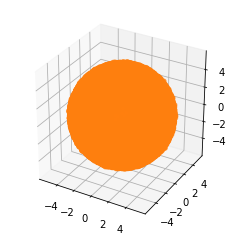

In [3]:
#### Plot the geometry ####

fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')

ax.view_init()#azim=0, elev=0)
ax.set_aspect('equal')
plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only
2. LSQ solving spherical harmonic coefficients for the displacement field
3. LSQ solving SH coeffs for the traction-free boundary

## 1. Assume $r$-direction deformation only

First thing to try is assuming that the deformation only happens on $r$-direction.

In [4]:
mu0 = 300/3;
mu = 1.; nu = 0.499;
lJmax = 20; lKmax = 20; lmax_plot = 80;

Vr = np.linalg.norm(Vp, axis=1)
Vthe = np.arccos(Vp[:,2]/Vr)
Vphi = np.arctan2(Vp[:,1], Vp[:,0])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)

# displacement on the unit sphere
u1 = -(r0/Vr[:,np.newaxis]-1)*Vp #(Vr/r0-1)[...,np.newaxis]*Vp
print(u1.shape)

(7800, 3)


In [5]:
import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

shtype = 'reg'

Umodes = loadmat('Umodes.mat')
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3)

Tmodes = loadmat('Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3)

In [6]:
# procedures for transformation between Uvec and Tvec, and visualizing SHvectors

def Uvec2Tvec(Uvec, Cmat, Dmat, disp=False):
    tic = time.time()
    B = spm.linalg.lsqr(Dmat, Uvec.T)
    toc = time.time()
    B_sol = B[0]
    print('Residual:', B[3], 'Time:', toc-tic, 'Solution:', B_sol.size)
    if disp:
        disp_index_sol = print_SH_mode(B_sol, m_dir=3, etol=1e-8)
    return Cmat.dot(B_sol)

def Tvec2Uvec(Tvec, Cmat, Dmat, disp=False):
    tic = time.time()
    A = spm.linalg.lsqr(Cmat, Tvec.T)
    toc = time.time()
    A_sol = A[0]
    print('Residual:', A[3], 'Time:', toc-tic, 'Solution:', A_sol.size)
    if disp:
        disp_index_sol = print_SH_mode(A_sol, m_dir=3, etol=1e-8)
    return Dmat.dot(A_sol)

def visSHVec(xvec, lmax_plot=None, cmap='viridis', show=True, 
             SphCoord=True, config_quiver=(2, 4, 'k', 1), n_vrange=None,
             lonshift=0, Complex=False, mesh=False, figsize=(10, 5)):
    if lmax_plot is None:
        lmax_plot = (np.sqrt(xvec.size/3) - 1).astype(np.int)
    cvec = xvec.reshape(3, -1)
    nvec = cvec.shape[1]
    xmesh= [None for _ in range(3)]
    for k in range(3):
        if Complex:
            cext = np.zeros((lmax_plot+1)**2, dtype=np.complex)
            cext[:nvec] = cvec[k, :]
            cilm = SHVectorToCilm(cext)
        else:
            cext = np.zeros((lmax_plot+1)**2)
            cext[:nvec] = cvec[k, :]
            cilm = pyshtools.shio.SHVectorToCilm(cext)
        coeffs = pyshtools.SHCoeffs.from_array(cilm)
        grid = coeffs.expand('GLQ')
        xmesh[k] = grid.to_array().real
    xmesh = np.stack(xmesh, axis=-1)
    if SphCoord:
        Q = TransMat(lJmax=lmax_plot)
        xmesh = np.sum(Q*xmesh[...,np.newaxis,:], axis=-1)
        
        fig = [None for _ in range(2)]
        ax = [None for _ in range(2)]
        xshear= np.linalg.norm(xmesh[...,1:], axis=-1)
        
        fig[0], ax[0] = plotfv(xmesh[...,0], show=False, cmap=cmap,vrange=n_vrange,
                               lonshift=lonshift, figsize=figsize)
        ax[0].set_title('norm')
        
        fig[1], ax[1] = plotfv(xshear, show=False, cmap='Reds', lonshift=lonshift, figsize=figsize)
        lons, lats = np.meshgrid(grid.lons(), grid.lats())
        xshift = np.roll(xmesh, np.round(lons.shape[1]*lonshift/360).astype(np.int), axis=1)
        st, dq, color, scale = config_quiver
        ax[1].quiver(lons[::dq,st::dq], lats[::dq,st::dq], 
                     xshift[::dq,st::dq,1], xshift[::dq,st::dq,2], 
                     color=color, scale=scale)
        ax[1].set_title('shear')
    else:
        fig = [None for _ in range(3)]
        ax = [None for _ in range(3)]
        titlestr = ('x', 'y', 'z')
        for k in range(3):
            fig[k], ax[k] = plotfv(xmesh[...,k], show=False, cmap=cmap, lonshift=lonshift, figsize=figsize)
            ax[k].set_title('$'+titlestr[k]+'$')
    if show:
        plt.show()
    if mesh:
        return xmesh
    return fig, ax

def visSH3d(xmesh, cmesh=None, r0=1, lmax_plot=None,
            figsize=(16,16), show=True, filename=None,
            elevation=0, azimuth=0):
    if lmax_plot is None:
        lmax_plot = xmesh.shape[0] - 1
    lats, lons = pyshtools.expand.GLQGridCoord(lmax_plot)
    nlat = lats.size; nlon = lons.size;

    lats_circular = np.hstack(([90.], lats, [-90.]))
    lons_circular = np.append(lons, [lons[0]])
    u = np.radians(lons_circular)
    v = np.radians(90. - lats_circular)
    normvec = np.zeros((nlat+2, nlon+1, 3))
    normvec[...,0] = np.sin(v)[:, None] * np.cos(u)[None, :]
    normvec[...,1] = np.sin(v)[:, None] * np.sin(u)[None, :]
    normvec[...,2] = np.cos(v)[:, None] * np.ones_like(lons_circular)[None, :]

    upoints = np.zeros((nlat + 2, nlon + 1, 3))
    upoints[1:-1, :-1, :] = xmesh
    upoints[0, :, :] = np.mean(xmesh[0,:,:], axis=0)  # not exact !
    upoints[-1, :, :] = np.mean(xmesh[-1,:,:], axis=0)  # not exact !
    upoints[1:-1, -1, :] = xmesh[:, 0, :]
    upoints *= r0
    
    x = r0 * np.sin(v)[:, None] * np.cos(u)[None, :]  + upoints[..., 0]
    y = r0 * np.sin(v)[:, None] * np.sin(u)[None, :] + upoints[..., 1]
    z = r0 * np.cos(v)[:, None] * np.ones_like(lons_circular)[None, :] + upoints[...,2]

    if cmesh is None:
        magn_point = np.sum(normvec * upoints, axis=-1)
    else:
        tpoints = np.zeros((nlat + 2, nlon + 1, 3))
        tpoints[1:-1, :-1, :] = cmesh
        tpoints[0, :, :] = np.mean(cmesh[0,:,:], axis=0)  # not exact !
        tpoints[-1, :, :] = np.mean(cmesh[-1,:,:], axis=0)  # not exact !
        tpoints[1:-1, -1, :] = cmesh[:, 0, :]
        magn_point = np.sum(normvec * tpoints, axis=-1)
    magn_face = 1./4. * (magn_point[1:, 1:] + magn_point[:-1, 1:] +
                         magn_point[1:, :-1] + magn_point[:-1, :-1])
    magnmax_face = np.max(np.abs(magn_face))
    magnmax_point = np.max(np.abs(magn_point))
    norm = plt.Normalize(-magnmax_face / 2., magnmax_face / 2., clip=True)
    cmap = plt.get_cmap('RdBu_r')
    colors = cmap(norm(magn_face.flatten()))
    colors = colors.reshape(nlat + 1, nlon, 4)

    fig = plt.figure(figsize=figsize)
    ax3d = fig.add_subplot(1, 1, 1, projection='3d')
    ax3d.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=colors)
    ax3d.view_init(elev=elevation, azim=azimuth)
    ax3d.tick_params(labelsize=16)

    if filename is not None:
        plt.tight_layout()
        fig.savefig(filename,transparent=True)
    if show:
        plt.show(block=True)
    return fig, ax3d

def SHvec_rtoc(xvec):
    rcilm = pyshtools.shio.SHVectorToCilm(xvec)
    ccilm = pyshtools.shio.SHrtoc(rcilm)
    cilm = np.zeros_like(ccilm, dtype=np.complex)
    cilm[0,...] = ccilm[0,...] + 1.j*ccilm[1,...]
    cilm[1,:,1:] = (-1)**m_coeffs(lJmax)[0,:,1:] * cilm[0,:,1:].conj()
    return SHCilmToVector(cilm)

def SHvec_ctor(xvec):
    cilm = SHVectorToCilm(xvec)
    ccilm = np.zeros_like(cilm, dtype=np.float)
    ccilm[0,...] = cilm[0,...].real
    ccilm[1,...] = cilm[0,...].imag
    rcilm = pyshtools.shio.SHctor(ccilm)
    return pyshtools.shio.SHCilmToVector(rcilm)

Residual: 0.22012038467183778
Residual: 0.2264484729820967
Residual: 0.21770870204607323
Displacement SH vector (real, complex): (1323,) (1323,)


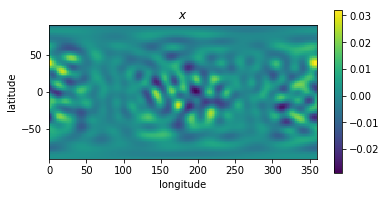

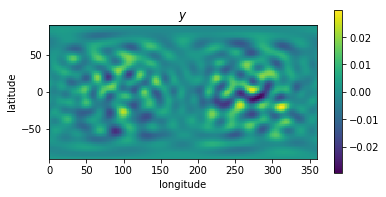

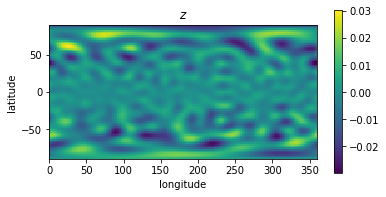

In [11]:
# decompose the displacements into spherical harmonic coefficients
Uvec_real = [None for _ in range(3)]
Uvec0 = [None for _ in range(3)]
for k in range(3):
    rcilm, chi2 = pyshtools.expand.SHExpandLSQ(u1[:,k]/r0, Vlat, Vlon, lmax=lJmax)
    print('Residual:', chi2)
    Uvec_real[k] = pyshtools.shio.SHCilmToVector(rcilm)
    Uvec0[k] = SHvec_rtoc(Uvec_real[k])
Uvec_real = np.hstack(Uvec_real)
Uvec0 = np.hstack(Uvec0)
print('Displacement SH vector (real, complex):', Uvec_real.shape, Uvec0.shape)
# fig, ax = visSHVec(Uvec_real, lmax_plot=lmax_plot, SphCoord=False, lonshift=180, figsize=(6,3))
fig, ax = visSHVec(Uvec0*r0, lmax_plot=lmax_plot, SphCoord=False, Complex=True, lonshift=180, figsize=(6,3))

Displacement in Spherical Coordinates...


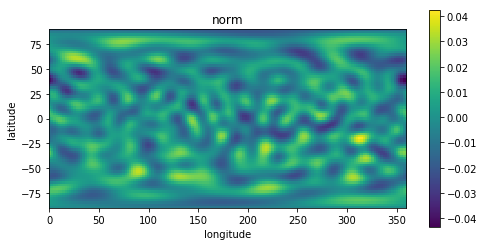

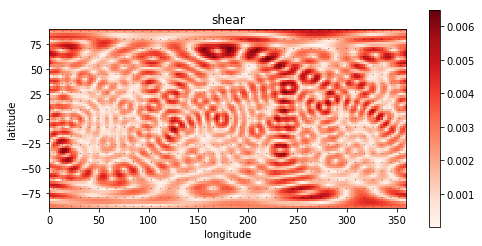

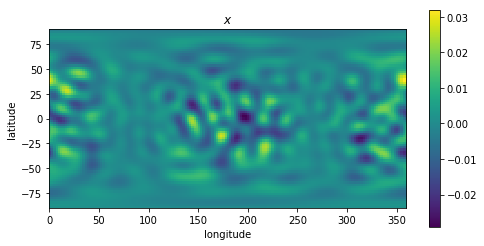

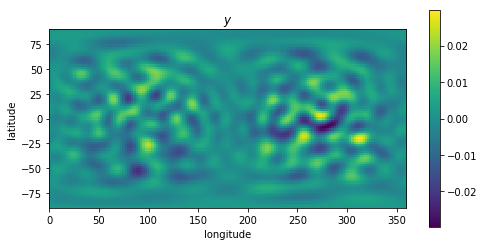

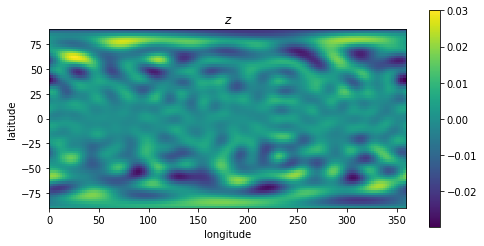

In [12]:
print('Displacement in Spherical Coordinates...')
umesh0 = visSHVec(Uvec0*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                  config_quiver=(2, 4, 'k', 1), lonshift=180, figsize=(8,4), mesh=True)/r0
umesh0 = visSHVec(Uvec0*r0, lmax_plot=lmax_plot, SphCoord=False, Complex=True, 
                  config_quiver=(2, 4, 'k', 1), lonshift=180, figsize=(8,4), mesh=True)/r0

Then we obtain the corresponding traction field.

Residual: 3.770339895113972e-07 Time: 0.1004488468170166 Solution: 1323
Traction in Spherical Coordinates...


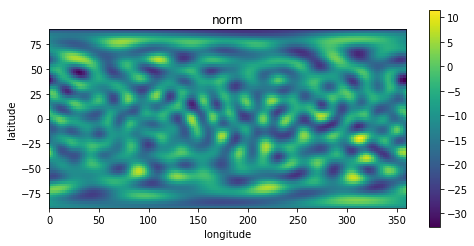

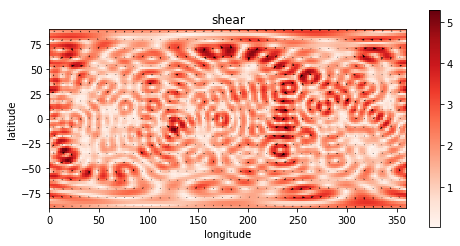

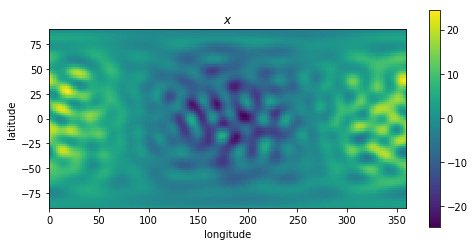

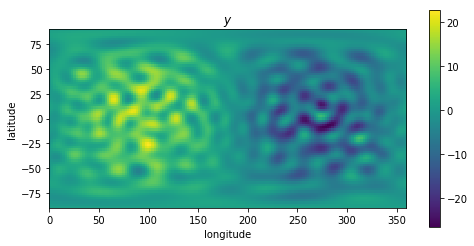

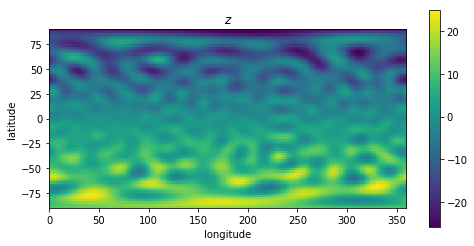

In [13]:
Tvec0 = Uvec2Tvec(Uvec0, Cmat, Dmat)
print('Traction in Spherical Coordinates...')
fig, ax = visSHVec(Tvec0*mu0, lmax_plot=80, lonshift=180, Complex=True,
                   config_quiver=(2,4,'k',400), figsize=(8,4))
tmesh0 = visSHVec(Tvec0*mu0, lmax_plot=80, lonshift=180, Complex=True, SphCoord=False,
                 config_quiver=(2,4,'k',400), figsize=(8,4), mesh=True)/mu0

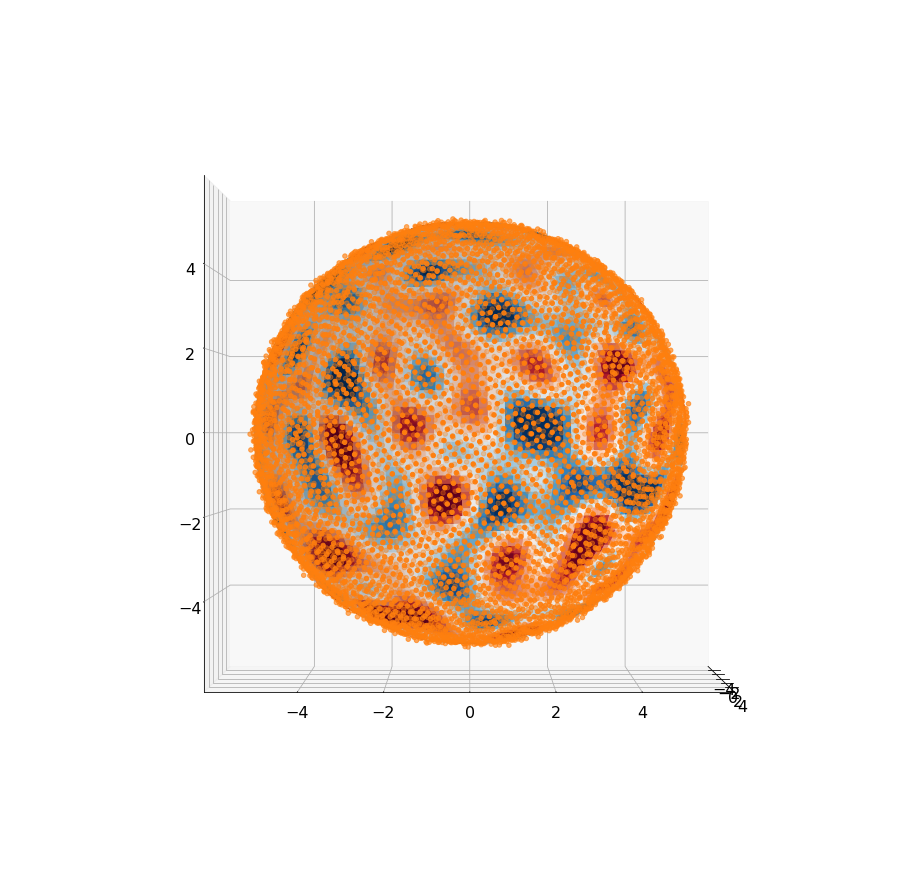

In [14]:
fig, ax = visSH3d(umesh0, r0=r0, show=False, elevation=0, azimuth=0)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')
plt.show()

We will see that the traction-free boundary is not well satisfies. Also, there are some viewable torque on the cap, which is obviously unphysical. We will need a better way to obtain the displacement field.

## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion. But here we will impose the coefficient for $Y_0^0$ to obtain the rigid body motion.

### 2.1 Developing distance function and neighbor list

We first develop the distance function of the point sets to the surface. The distance of a point $x$ to the surface is defined as: $d(x) = \min[d_{v}(x), d_{e}(x), d_{f}(x)]$, where $d_v(x)$, $d_e(x)$, $d_f(x)$ are the closest distances of $x$ to the vertices, edges, and faces respectively.

* For a vertex $v=(v_1,v_2,v_3)^T$, $d_v(x)=\|\mathbf{x-v}\|_2$. The test script is attached.

Original point [[0 0 0]]
Vertices [[0.09374353 0.16502496 0.43806432]
 [0.01865455 0.54306138 0.32946797]]
Distances [[0.47741118 0.63546267]]
Min distance 0.4774111834409994


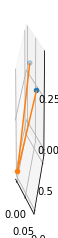

In [15]:
def d2v(Xs, Xv, avg_dist=True, vert_weight=1):
    #### point-to-point distance
    ## Xs: points for testing (..., 3); 
    ## Xv: m data points (m, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## vert_weight: the weighing function for different coordinates (3, )
    d2vmat = np.linalg.norm((Xs[..., np.newaxis, :]-Xv)*vert_weight, axis=-1)   # pair-wise distances (..., m)
    if avg_dist:
        return d2vmat.min(axis=-1).mean()
    else:
        return d2vmat

# test d2v function
Xs = np.array([0,0,0]).reshape(1,3)
Xv = np.random.rand(2,3)
print('Original point', Xs)
print('Vertices', Xv)
print('Distances', d2v(Xs, Xv, avg_dist=False))
print('Min distance', d2v(Xs, Xv))

fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')
ax.scatter3D([0, ],[0, ],[0, ], 'C1')

lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, (2,3)), Xv]).reshape((-1,2,3)), colors='C1')
ax.add_collection(lines_3d)

ax.view_init()
ax.set_aspect('equal')
plt.show()

* For an edge $e=(r_1, r_2)$, the projection point $\vec{r_1q}$ on $\vec{r_1r_2}$ is 
$$
\vec{r_1q} = \frac{\vec{r_1x}\cdot\vec{r_1r_2}}{\|\vec{r_1r_2}\|}\,\frac{\vec{r_1r_2}}{\|\vec{r_1r_2}\|}
$$

The projection is in the interval $r_1r_2$ if $t=\|\vec{r_1q}\|/\|\vec{r_1r_2}\|\in(0,1)$. 
Thus, the distance to the edge is calculated as:
$$
d_e(x)=
\begin{cases}
\|\vec{r_1x}\|,\; t\le0 \\
\|\vec{qx}\|,\; 0<t\le1 \\
\|\vec{r_2x}\|,\; t>1 
\end{cases}
$$
A test case is attached here.

Original point [[0 0 0]]
Edges:
[[[0.36318771 0.99398837 0.13508512]
  [0.2847952  0.58134558 0.9961131 ]]

 [[0.11306186 0.1997168  0.30705511]
  [0.88813162 0.58896699 0.22996105]]]
Closest dist: [[1.01240758 0.383344  ]] d2r1 [[1.06684872 0.383344  ]] d2r2 [[1.18798666 1.09020272]]
Actual dist: [[1.01240758        inf]]
min distance: 0.3833440004559572 0.0002300739288330078 s
cached calculation: 0.3833440004559572 0.00019598007202148438 s


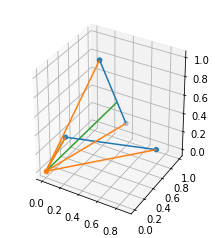

In [16]:
def d2e(Xs, Xe, e_cached=None, avg_dist=True, infval=False, debug=False):
    #### point-to-edge distance
    ## Xs: points for testing (..., 3); 
    ## Xe: m edges from data (m, 2, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## infval: if True, the projection outside the edge will be consider infinite distance
    ## debug: output info for debug/testing
    if e_cached is None:
        r1 = Xe[..., 0, :]; r2 = Xe[..., 1, :]; r12 = r2 - r1;        # m x 3, edge vertices
        l12 = np.linalg.norm(r12, axis=-1)                            # m,     edge length
    else:
        r1, r12, l12 = e_cached
    t = np.sum((Xs[..., np.newaxis, :]-r1)*r12, axis=-1)/l12**2   # n x m,     projection ratio
    t_cal = t.copy(); t_cal[t<0] = 0; t_cal[t>1] = 1;             # a copy of t for calculation
    q = r1 + (t_cal[...,np.newaxis]*r12)                          # n x m x 3, projection point
    d2emat = np.linalg.norm(Xs[..., np.newaxis, :] - q, axis=-1)  # n x m
    if infval:
        d2emat[np.logical_or(t<0, t>1)] = np.inf
    if avg_dist:
        return d2emat.min(axis=-1).mean()
    else:
        if debug:
            dr1 = np.linalg.norm(Xs[..., np.newaxis, :] - r1, axis=-1)
            dr2 = np.linalg.norm(Xs[..., np.newaxis, :] - r2, axis=-1)
            return (d2emat, q, dr1, dr2)
        else:
            return d2emat

# test d2e function
Xs = np.array([0,0,0]).reshape(1,3)
Xe = np.random.rand(2,2,3)
print('Original point', Xs); print('Edges:'); print(Xe);
d2emat, q, dr1, dr2 = d2e(Xs, Xe, avg_dist=False, debug=True)
q = q.squeeze()
print('Closest dist:', d2emat,'d2r1', dr1,'d2r2', dr2)
print('Actual dist:', d2e(Xs, Xe, avg_dist=False, infval=True))
tic = time.time(); d2emat = d2e(Xs, Xe); toc = time.time()
print('min distance:', d2emat, toc-tic, 's')
r1 = Xe[..., 0, :]; r2 = Xe[..., 1, :]; r12 = r2 - r1;        # m x 3, edge vertices
l12 = np.linalg.norm(r12, axis=-1)
e_cached = (r1, r12, l12)
tic = time.time(); d2emat = d2e(Xs, Xe, e_cached=e_cached); toc = time.time()
print('cached calculation:', d2emat, toc-tic, 's')
Xv = Xe.reshape(4, 3)

fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')
ax.scatter3D([0, ],[0, ],[0, ], 'C1')

edges = Line3DCollection(np.hstack([Xe[:,0,:], Xe[:,1,:]]).reshape((-1,2,3)), colors='C0')
ax.add_collection(edges)
lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, Xv.shape), Xv]).reshape((-1,2,3)), colors='C1')
ax.add_collection(lines_3d)
projection = Line3DCollection(np.hstack([np.broadcast_to(Xs, q.shape), q]).reshape((-1,2,3)), colors='C2')
ax.add_collection(projection)

ax.view_init()
ax.set_aspect('equal')
plt.show()

* For a face $f=(r_1, r_2, r_3)$, the normal vector:
$$
n = \frac{\vec{r_1r_2}\times\vec{r_1r_3}}{\|\vec{r_1r_2}\times\vec{r_1r_3}\|}
$$
Then the distance can be calculated as:
$$
d_f(x)=\|\vec{r_1x}\cdot\vec{n}\|
$$
if the projection point $q$ is in the triangle, where $q = x - (\vec{r_1x}\cdot\vec{n})\vec{n}$.

To test this, we calculate the barycentric coordinates of $q$:
$$
b_3 = \frac{\|r_1\|^2\times(\vec{r_1r_3}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_2}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_2 = \frac{\|r_2\|^2\times(\vec{r_1r_2}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_3}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_1 = 1 - b_2 - b_3
$$

If any $b_i < 0$, $q$ is outside of the triangle, we then calculate the point edge distances $d_e(x)$ instead.

[[[ 0.06580561  0.29041623  1.        ]
  [-0.07836731 -0.48616891  1.        ]
  [-0.06121081  0.1366447   1.        ]]

 [[ 0.17322566  1.         -0.31288711]
  [ 0.28208155  1.          0.35701417]
  [-0.05345319  1.         -0.4770697 ]]]
0.0008058547973632812
[[0. 0. 1.]
 [0. 1. 0.]]
total distance: 1.0 0.0007944107055664062 s
total distance with cache: 1.0 0.0004811286926269531 s
[[1.01114714 1.00006833 1.00210705]]
[[-0.06121081  0.1366447   1.        ]
 [ 0.01149373 -0.00213381  1.        ]
 [-0.06492566  0.00178849  1.        ]]
[[1.06202894 1.02416554 1.00821692]]
[[ 0.17322566  1.         -0.31288711]
 [ 0.21830411  1.         -0.03547342]
 [ 0.11917601  1.         -0.04794205]]


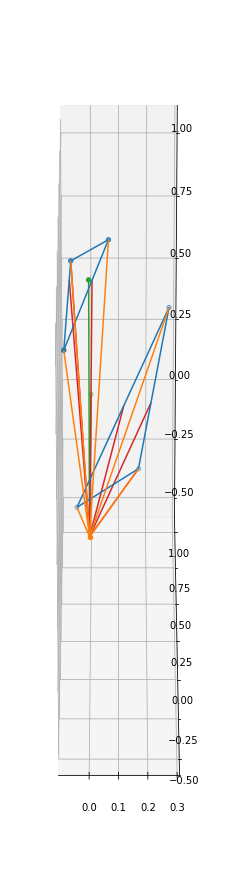

In [17]:
def generate_fcache(Xf):
    r0 = Xf[..., 0, :]; r1 = Xf[..., 1, :]; r2 = Xf[..., 2, :];    # m x 3
    nf = np.cross(r1-r0, r2-r0)                                    # normal vector
    nf = nf / np.linalg.norm(nf, axis=-1)[...,np.newaxis]          # m x 3
    r11 = np.sum((r2 - r0)**2, axis=-1)                            # m
    r00 = np.sum((r1 - r0)**2, axis=-1)                            # m
    r01 = np.sum((r1-r0)*(r2-r0), axis=-1)                         # m
    d = r11*r00 - r01*r01                                          # m
    return r0, r1, r2, nf, r00, r11, r01, d

def d2f(Xs, Xf, f_cached=None, avg_dist=True, infval=False, debug=False, vert_weight=1):
    #### point-to-face distance
    ## Xs: points for testing (..., 3); 
    ## Xf: m faces from data (m, 3, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## infval: if True, the projection outside the face will be consider infinite distance
    ## debug: output info for debug/testing
    ## vert_weight: the weighing function for different coordinates (3, )
    
    if f_cached is None:
        f_cached = generate_fcache(Xf)
    r0, r1, r2, nf, r00, r11, r01, d = f_cached
    pq = np.sum((Xs[...,np.newaxis,:]-r0)*nf*vert_weight, axis=-1)     # n x m
    q = Xs[...,np.newaxis,:] - pq[...,np.newaxis]*nf               # n x m x 3, projection point
    d2fmat = np.abs(pq)                                            # n x m

    # determine the barycentric coordinate of q
    r12  = np.sum((r2-r0)*(q-r0), axis=-1)                         # n x m
    r02  = np.sum((r1-r0)*(q-r0), axis=-1)                         # n x m
    bary = np.zeros_like(q)                                        # n x m x 3
    bary[...,2] = (r00*r12-r01*r02)/d
    bary[...,1] = (r11*r02-r01*r12)/d
    bary[...,0] = 1 - bary[...,1] - bary[...,2]
    out = np.any(bary < 0, axis=-1)                                # n x m

    # determine the closest point on the edges
    Xfv= np.broadcast_to(Xf, q.shape+(3,))[out]                    # n_out x 3 x 3
    Xp = np.broadcast_to(Xs[...,np.newaxis,:], q.shape)[out]       # n_out x 3
    ve = np.roll(Xfv, 1, axis=-2)-Xfv                              # n_out x 3 x 3
    le = np.linalg.norm(ve, axis=-1)                               # n_out x 3
    ts = np.sum(ve*(Xp[...,np.newaxis,:]-Xfv), axis=-1)/le**2      # n_out x 3
    ts[ts > 1] = 1; ts[ts < 0] = 0;
    qs = Xfv+(ts[...,np.newaxis]*ve)
    dq = np.linalg.norm(((Xp[...,np.newaxis,:]-qs)*vert_weight), axis=-1)       # n_out x 3
    d2fmat[out] = np.min(dq, axis=-1)
    if avg_dist:
        return d2fmat.min(axis=-1).mean()
    if debug:
        return (d2fmat, q)
    else:
        return d2fmat

# test d2e function
Xs = np.array([0,0,0]).reshape(1,3)
Xf = np.random.rand(2,3,3)-0.5
Xf[0,:,2] = 1
Xf[1,:,1] = 1
Xv = Xf.reshape(6, 3)
print(Xf)
Xe = np.vstack([np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1),
                np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1)])
tic = time.time()
d2fmat, q = d2f(Xs, Xf, avg_dist=False, debug=True);
toc = time.time()
print(toc-tic)

q = np.squeeze(q)
d2e1, q1, _, _ = d2e(Xs, np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
d2e2, q2, _, _ = d2e(Xs, np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
q1 = q1.squeeze(); q2 = q2.squeeze();

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')
ax.scatter3D([0, ],[0, ],[0, ], 'C1')
ax.scatter3D(q[..., 0], q[..., 1], q[..., 2], 'C2')
print(q)
tic = time.time(); d2fmat = d2f(Xs, Xf); toc = time.time()
print('total distance:', d2fmat, toc-tic, 's')
f_cached = generate_fcache(Xf)
tic = time.time(); d2fmat = d2f(Xs, Xf, f_cached=f_cached); toc = time.time()
print('total distance with cache:', d2fmat, toc-tic, 's')
print(d2e1); print(q1);
print(d2e2); print(q2);

edges = Line3DCollection(np.hstack([Xe[:,0,:], Xe[:,1,:]]).reshape((-1,2,3)), colors='C0')
ax.add_collection(edges)
lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, Xv.shape), Xv]).reshape((-1,2,3)), colors='C1')
ax.add_collection(lines_3d)
projection = Line3DCollection(np.hstack([np.broadcast_to(Xs, q.shape), q]).reshape((-1,2,3)), colors='C2')
ax.add_collection(projection)
projection1 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q1.shape), q1]).reshape((-1,2,3)), colors='C3')
ax.add_collection(projection1)
projection2 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q2.shape), q2]).reshape((-1,2,3)), colors='C3')
ax.add_collection(projection2)

ax.view_init(azim=270, elev=30)
ax.set_aspect('equal')
plt.show()

With the distance function ready, we can develop the neighbor list by choosing the closest 70 vertices, edges and faces to the points:

In [18]:
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon = np.deg2rad(lonsdeg)
colat = np.deg2rad(90-latsdeg)
PHI, THETA = np.meshgrid(lon, colat)
R = np.ones_like(PHI)
X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
X0 = np.stack([X,Y,Z], axis=-1)
Xt = X0 + visSHVec(Uvec0, lmax_plot=lJmax, SphCoord=False, Complex=True, show=False,
                   config_quiver=(2, 4, 'k', 1), lonshift=180, figsize=(8,4), mesh=True)

In [19]:
d2vmat = d2v(Xt, Vp/r0, avg_dist=False)
n_list = 70
d2varg = np.argsort(d2vmat)[...,:n_list]
Xneigh = Vp[d2varg]/r0
print('Neighbor list:', Xneigh.shape)

Neighbor list: (21, 41, 70, 3)


### 2.2  From `uvec` to the shape difference

After we obtain the neighbor list, the shape can be obtained from the real SH vector `uvec`. This can be used for the optimization of the shape.

In [20]:
def coeffs2dist(xvec, Xt=None, f_cached=None, lmax=None, X0=None, Complex=False, 
                lat_weights=1, vert_weight=1):
    #### shape difference from SH vectors
    ## xvec: Input real SH vector (3x(lmax+1)^2)
    ## Xt: Input shape data (nv x 3) or (nf x 3 x 3); can be full list or neighbor list
    ## f_cached: Default None, Xt is the coordinates of vertices; otherwise, Xt is the
    ##          coordinates of faces, and f_cached provides the pre-calculated values.
    ## lmax, X0: pre-calculated parameters for speed-up. Explained in the code.
    ## Complex: Default False, xvec is the real SH vector using pyshtools.shio.SHVectorToCilm;
    ##          otherwise, it will be complex SH vector using SHUtil.SHVectorToCilm;
    ## lat_weights, vert_weight: weighing function for the points on different lattitudes.
    if lmax is None:
        lmax = np.sqrt(xvec.size/3).astype(np.int) - 1
    nvec = (lmax+1)**2
    cvec = xvec.reshape(3, nvec)
    # expand the displacement field onto a mesh
    umesh= [None for _ in range(3)]
    for k in range(3):
        if Complex:
            cilm = SHVectorToCilm(cvec[k, :])
        else:
            cilm = pyshtools.shio.SHVectorToCilm(cvec[k, :])
        coeffs = pyshtools.SHCoeffs.from_array(cilm)
        grid = coeffs.expand('GLQ')
        umesh[k] = grid.to_array().real
    umesh = np.stack(umesh, axis=-1)
    # calculate the shape
    if X0 is None:
        lon = np.deg2rad(grid.lons())
        colat = np.deg2rad(90-grid.lats())
        PHI, THETA = np.meshgrid(lon, colat)
        R = np.ones_like(PHI)
        X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
        X0 = np.stack([X,Y,Z], axis=-1)
    Xs = X0 + umesh

    if f_cached is None:
        #d2surf = d2v(Xs, Xt, avg_dist=False, vert_weight=vert_weight).min(axis=-1)
        d2surf = np.sum((Xs[..., np.newaxis, :]-Xt)**2*lat_weights*vert_weight, axis=-1).min(axis=-1)
    else:
        #d2surf = d2f(Xs, Xt, f_cached=f_cached, avg_dist=False, vert_weight=vert_weight).min(axis=-1)
        r0, r1, r2, nf, r00, r11, r01, d = f_cached; Xf = Xt;
        pq = np.sum((Xs[...,np.newaxis,:]-r0)*nf, axis=-1)             # n x m
        q = Xs[...,np.newaxis,:] - pq[...,np.newaxis]*nf               # n x m x 3, projection point
        d2fmat = np.sum(((Xs[...,np.newaxis,:]-r0)*nf)**2*vert_weight, axis=-1)   # n x m

        # determine the barycentric coordinate of q
        r12  = np.sum((r2-r0)*(q-r0), axis=-1)                         # n x m
        r02  = np.sum((r1-r0)*(q-r0), axis=-1)                         # n x m
        bary = np.zeros_like(q)                                        # n x m x 3
        bary[...,2] = (r00*r12-r01*r02)/d
        bary[...,1] = (r11*r02-r01*r12)/d
        bary[...,0] = 1 - bary[...,1] - bary[...,2]
        out = np.any(bary < 0, axis=-1)                                # n x m

        # determine the closest point on the edges
        Xfv= np.broadcast_to(Xf, q.shape+(3,))[out]                    # n_out x 3 x 3
        Xp = np.broadcast_to(Xs[...,np.newaxis,:], q.shape)[out]       # n_out x 3
        ve = np.roll(Xfv, 1, axis=-2)-Xfv                              # n_out x 3 x 3
        le = np.linalg.norm(ve, axis=-1)                               # n_out x 3
        ts = np.sum(ve*(Xp[...,np.newaxis,:]-Xfv), axis=-1)/le**2      # n_out x 3
        ts[ts > 1] = 1; ts[ts < 0] = 0;
        qs = Xfv+(ts[...,np.newaxis]*ve)
        dq = np.sum((Xp[...,np.newaxis,:]-qs)**2*vert_weight, axis=-1)       # n_out x 3
        d2fmat[out] = np.min(dq, axis=-1)
        d2surf = d2fmat.min(axis=-1)

    return np.sqrt(np.mean(d2surf*lat_weights))

We use the solution we obtained from Section 1 `Uvec_real` for the testing:

In [22]:
err_ratio = 1/3.2
#lat_weights = ((1-err_ratio)*np.sin(colat)+err_ratio)**2
lat_weights = np.sin(colat).reshape(-1, 1, 1, 1)
vert_weight = np.array([1,1,1.])
print('latitude weight function shape:', lat_weights.shape, vert_weight.shape)

tic = time.time()
dist_test = coeffs2dist(Uvec_real*0, Vp/r0, lmax=lJmax, X0=X0)#, lat_weights=lat_weights, vert_weight=vert_weight)*r0
toc = time.time()
print('compare all distances: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(Uvec_real*0, Xneigh, lmax=lJmax, X0=X0)#, lat_weights=lat_weights, vert_weight=vert_weight)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

latitude weight function shape: (21, 1, 1, 1) (3,)
compare all distances: dist = 0.01856927, time = 0.6062
compare only neighbor list: dist = 0.01856927, time = 0.0095


### 2.4 Solution by minimizing the shape-shape difference

Then we can optimizing the solution by minimizing the distance:

In [23]:
# minimize the distance by variate coefficients
from scipy.optimize import minimize

tic = time.time()
uvec_min = minimize(coeffs2dist, Uvec_real*0,
                args=(Xneigh, None, lJmax, X0, False, lat_weights, vert_weight), #method='Powell')
                method='CG',options={'gtol': 1e-5, 'disp': True})
toc = time.time()
print('total time', toc-tic)

Optimization terminated successfully.
         Current function value: 0.007256
         Iterations: 10
         Function evaluations: 29150
         Gradient evaluations: 22
total time 217.48570370674133


In [24]:
tic = time.time()
dist_test = coeffs2dist(uvec_min.x, Xneigh, lmax=lJmax, X0=X0)
toc = time.time()
print('the actual v2v distances per node: dist = %.8f, time = %.4fs'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(uvec_min.x, Xneigh, lmax=lJmax, X0=X0, lat_weights=lat_weights)
toc = time.time()
print('node-density weighted v2v distances per node: dist = %.8f, time = %.4fs'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(uvec_min.x, Xneigh, lmax=lJmax, X0=X0, lat_weights=lat_weights, vert_weight=vert_weight)
toc = time.time()
print('noise-weighted v2v distances per node: dist = %.8f, time = %.4fs'%(dist_test, toc-tic))

the actual v2v distances per node: dist = 0.01233154, time = 0.0202s
node-density weighted v2v distances per node: dist = 0.00725642, time = 0.0178s
noise-weighted v2v distances per node: dist = 0.00725642, time = 0.0203s


Displacement in Spherical Coordinates...


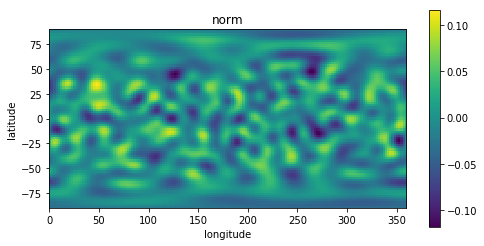

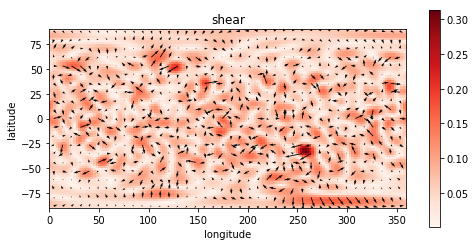

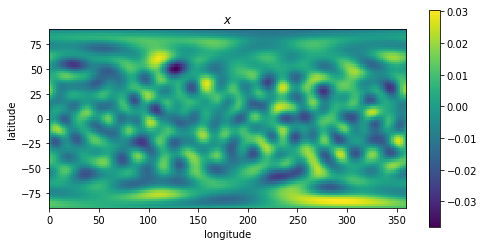

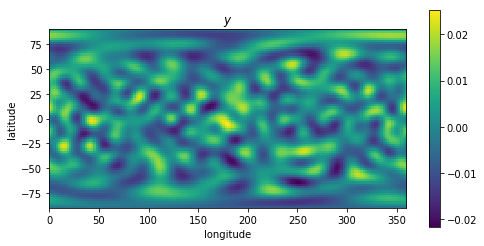

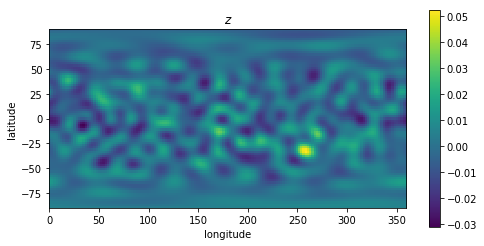

noise-weighted v2f distances per node: dist = 0.00725642, time = 0.0278s


In [26]:
lat_weights = lat_weights.reshape(-1, 1, 1, 1)
Uvec1_real = uvec_min.x.reshape((3, -1)) #(uvec_min.x*l_weight).reshape((3, -1))/r0
Uvec1 = np.zeros_like(Uvec1_real, dtype=np.complex)
for k in range(3):
    Uvec1[k, :] = SHvec_rtoc(Uvec1_real[k, :])
Uvec1 = Uvec1.flatten()
print('Displacement in Spherical Coordinates...')
umesh1 = visSHVec(Uvec1*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, config_quiver=(2, 4, 'k', 5), lonshift=180, figsize=(8,4), mesh=True)/r0
umesh1 = visSHVec(Uvec1_real, lmax_plot=lmax_plot, SphCoord=False, Complex=False, config_quiver=(2, 4, 'k', 5), lonshift=180, figsize=(8,4), mesh=True)
#f_cached = generate_fcache(Fneigh)
tic = time.time()
dist_test = coeffs2dist(Uvec1, Xneigh, lmax=lJmax, X0=X0, lat_weights=lat_weights, vert_weight=vert_weight, Complex=True)
toc = time.time()
print('noise-weighted v2f distances per node: dist = %.8f, time = %.4fs'%(dist_test, toc-tic))

Residual: 1.312014168035995e-06 Time: 0.20291495323181152 Solution: 1323
Traction in Spherical Coordinates...


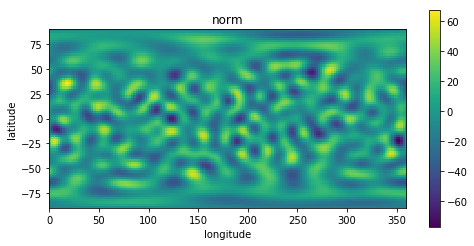

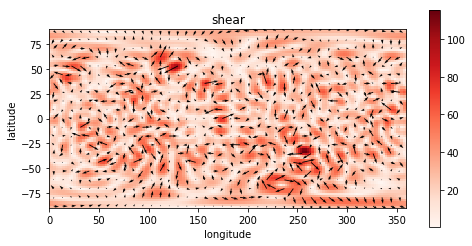

In [27]:
Tvec1 = Uvec2Tvec(Uvec1, Cmat, Dmat)
print('Traction in Spherical Coordinates...')
tmesh1 = visSHVec(Tvec1*mu0, lmax_plot=80, lonshift=180, Complex=True, config_quiver=(2,4,'k',2000), figsize=(8,4), mesh=True)/mu0

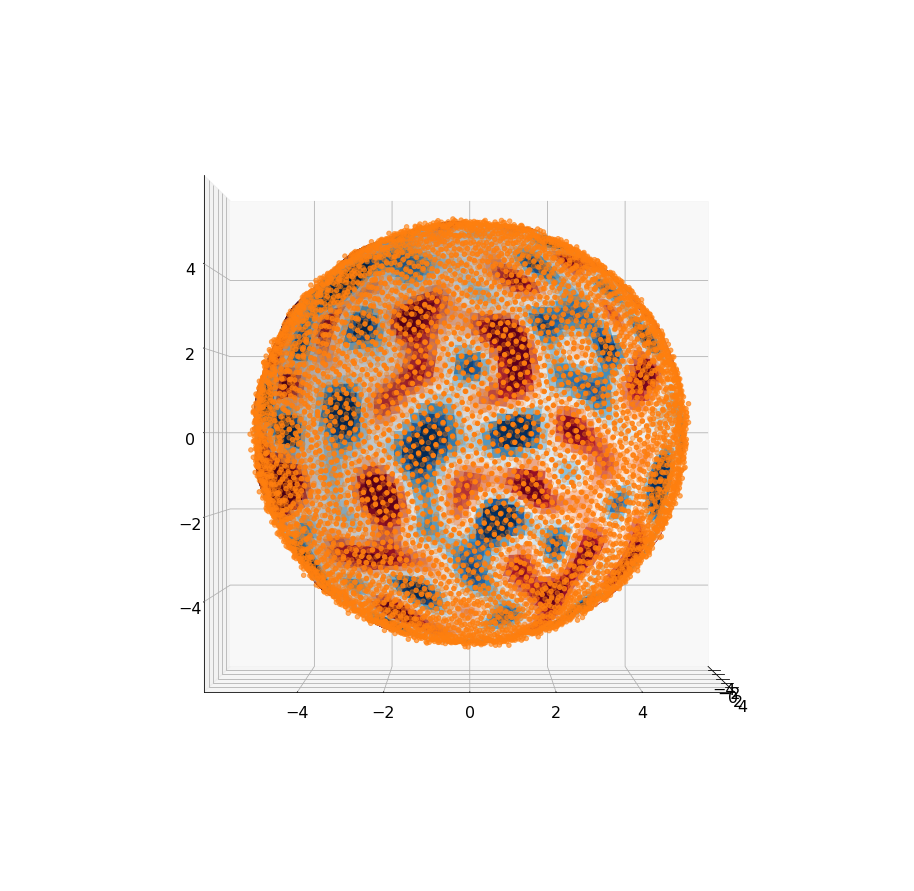

In [28]:
fig, ax = visSH3d(umesh1, r0=r0, show=False, elevation=0)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')
plt.show()

## 3. Optimize the solution in the solution space to satisfy the mixed BC

The problem actually includes a mixed BC on shape and traction. In order to optimize the two targets together, we use the vector $a^{(K)}$ as the parameters, and we can obtain the traction and shape by superposing the fundamental solutions

$$
\mathbf{T}=a^{(K)}\mathbf{T}^{(K)}\\
\mathbf{u}=a^{(K)}\mathbf{u}^{(K)}
$$
then the shape is calculated as $\mathbf{x}=\mathbf{X}+\mathbf{u}$.

The target function: to do

We first find the nodes that is on the traction free boundary

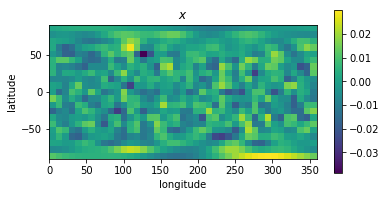

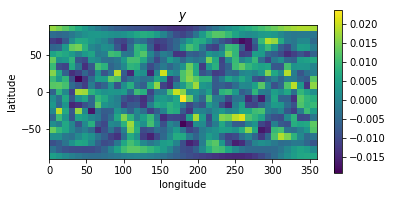

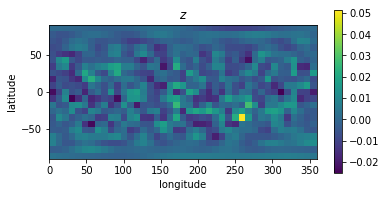

(21, 41, 3) (21, 41, 3) (21, 41)


In [31]:
umesh = visSHVec(Uvec1, SphCoord=False, Complex=True, config_quiver=(1, 1, 'k', 1), lonshift=180, figsize=(6, 3), mesh=True)
x0 = X0 + umesh
dist2mat = np.linalg.norm(x0[..., np.newaxis, :] - Vp/r0, axis=-1)
arg_list_x = dist2mat.argmin(axis=-1)
isTfv = Tfv[arg_list_x]

print(umesh.shape, X0.shape, isTfv.shape)

Then we optimize the vector $a^{(K)}$:

In [50]:
lat_weights = lat_weights.flatten()

def sol2dist(aK, Cmat, Dmat, alpha = 0.05, separate=False):
    Tvec = Cmat.dot(aK)
    Uvec = Dmat.dot(aK)
    nvec = (lJmax+1)**2
    ucvec = Uvec.reshape(3, -1)
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    umesh = np.empty((lJmax+1, 2*lJmax+1, 3))
    tmesh = np.empty((lJmax+1, 2*lJmax+1, 3))
    for k in range(3):
        ucilm = SHVectorToCilm(ucvec[k, :])
        ugrid = pyshtools.SHCoeffs.from_array(ucilm).expand('GLQ')
        umesh[..., k] = ugrid.to_array().real
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    Xs = X0 + umesh# + u0.real
    
    d2surf = np.sum((Xs[..., np.newaxis, :]-Xneigh)**2*vert_weight, axis=-1).min(axis=-1)
    Udist = np.sqrt(np.mean(d2surf*lat_weights[:,np.newaxis]))
    tvalues = np.sum(tmesh**2*vert_weight, axis=-1)
    Tdist = np.sqrt(np.mean(tvalues*lat_weights[:,np.newaxis]))
    if separate:
        return (Udist, Tdist)
    return (Udist + alpha*Tdist)*1e3

In [52]:
from SHUtil import LM_list
A = spm.linalg.lsqr(Cmat, Tvec1.T)
Ainf = A[0]
print(A[3])

alpha = 0.5
tic = time.time()
Asol = sol2dist(Ainf, Cmat, Dmat, alpha=alpha, separate=True)
toc = time.time()
print('infinite traction:', Asol, toc-tic)

6.786307045559735e-05
infinite traction: (0.00930295295587206, 0.29299141220126385) 0.007105827331542969


In [53]:
tic = time.time()
Amin = minimize(sol2dist, Ainf,
                args=(Cmat, Dmat, alpha, False), method='Powell', options={'disp': True})
toc = time.time()
print('total time', toc-tic)
#np.save(Aminfile, Amin)

/usr/local/lib/python3.5/dist-packages/scipy/optimize/optimize.py:2471: ComplexWarning: Casting complex values to real discards the imaginary part
  direc[-1] = direc1


Optimization terminated successfully.
         Current function value: 105.619974
         Iterations: 56
         Function evaluations: 1224164
total time 9036.05216217041


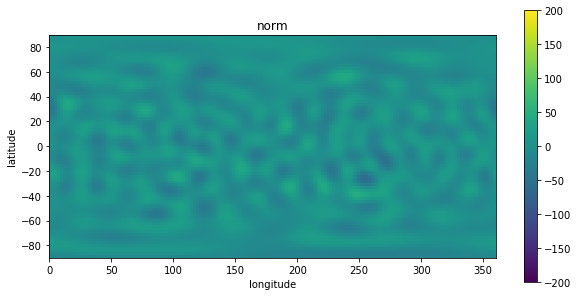

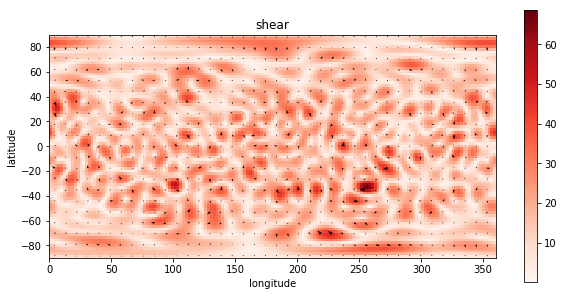

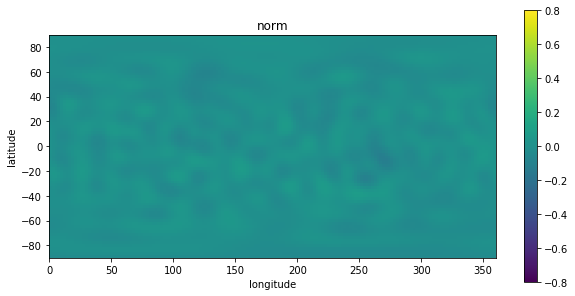

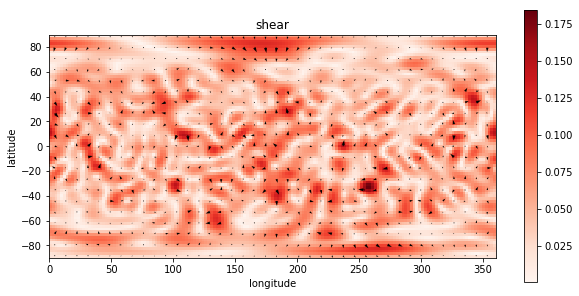

infinite traction: (0.012310460488181475, 0.18661902720461881) 0.027962923049926758


In [54]:
aKmin = Amin.x
#print(aKmin.shape)
aKmin = Amin.x #Amin.x[:-3];# u0 = Amin.x[-3:];
Tvecmin = Cmat.dot(aKmin)
Uvecmin = Dmat.dot(aKmin)
fig, ax = visSHVec(Tvecmin*mu0, lmax_plot=80, lonshift=180,n_vrange=(-200,200), Complex=True, config_quiver=(2,4,'k', 4000), show=False)
#fig[0].savefig(Aminfile+'_Tn.eps', transparent=True)
#fig[1].savefig(Aminfile+'_Ts.eps', transparent=True)
fig, ax = visSHVec(Uvecmin*r0, lmax_plot=80, lonshift=180, n_vrange=(-0.8,0.8), Complex=True, config_quiver=(2,4,'k', 10))
#fig[0].savefig(Aminfile+'_un.eps', transparent=True)
#fig[1].savefig(Aminfile+'_us.eps', transparent=True)

tic = time.time()
Asol = sol2dist(Amin.x, Cmat, Dmat, alpha=alpha, separate=True)
toc = time.time()
print('infinite traction:', Asol, toc-tic)
#print('point-trimesh distance:',
#      coeffs2dist(Uvecmin, Fneigh, f_cached=f_cached,
#                  lmax=lJmax, Complex=True, X0=X0,
#                  lat_weights=lat_weights[:,np.newaxis], vert_weight=vert_weight)*r0)

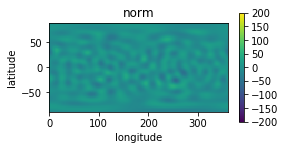

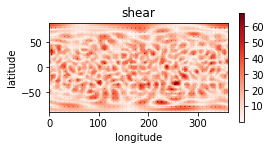

(81, 161, 3)


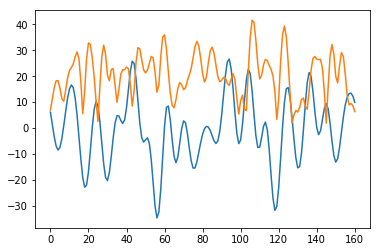

In [55]:
tmesh = visSHVec(Tvecmin*mu0, lmax_plot=80, lonshift=180,n_vrange=(-200,200), Complex=True, config_quiver=(2,4,'k', 4000),figsize=(4,2), mesh=True)
print(tmesh.shape)
tsmag = np.linalg.norm(tmesh[41, :, 1:], axis=-1)
plt.plot(np.roll(tmesh[41, :, 0], 81))
plt.plot(np.roll(tsmag, 81))
plt.show()

Then we will visualize the shape in 3D:

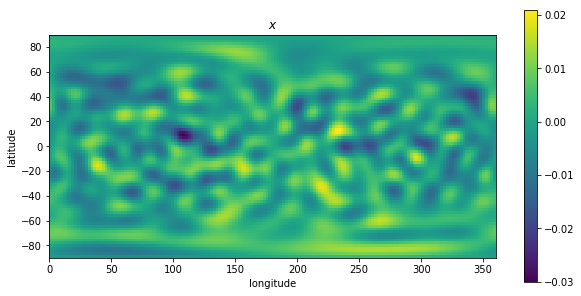

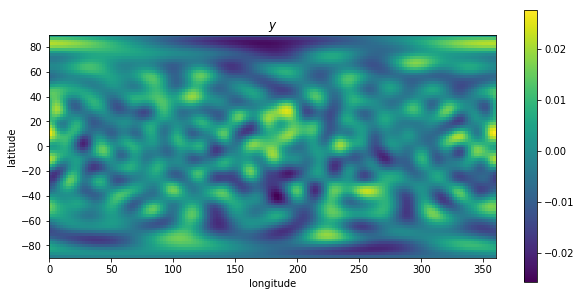

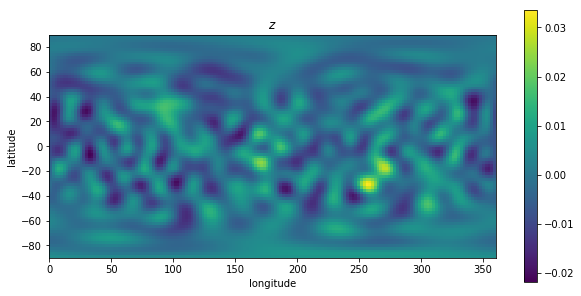

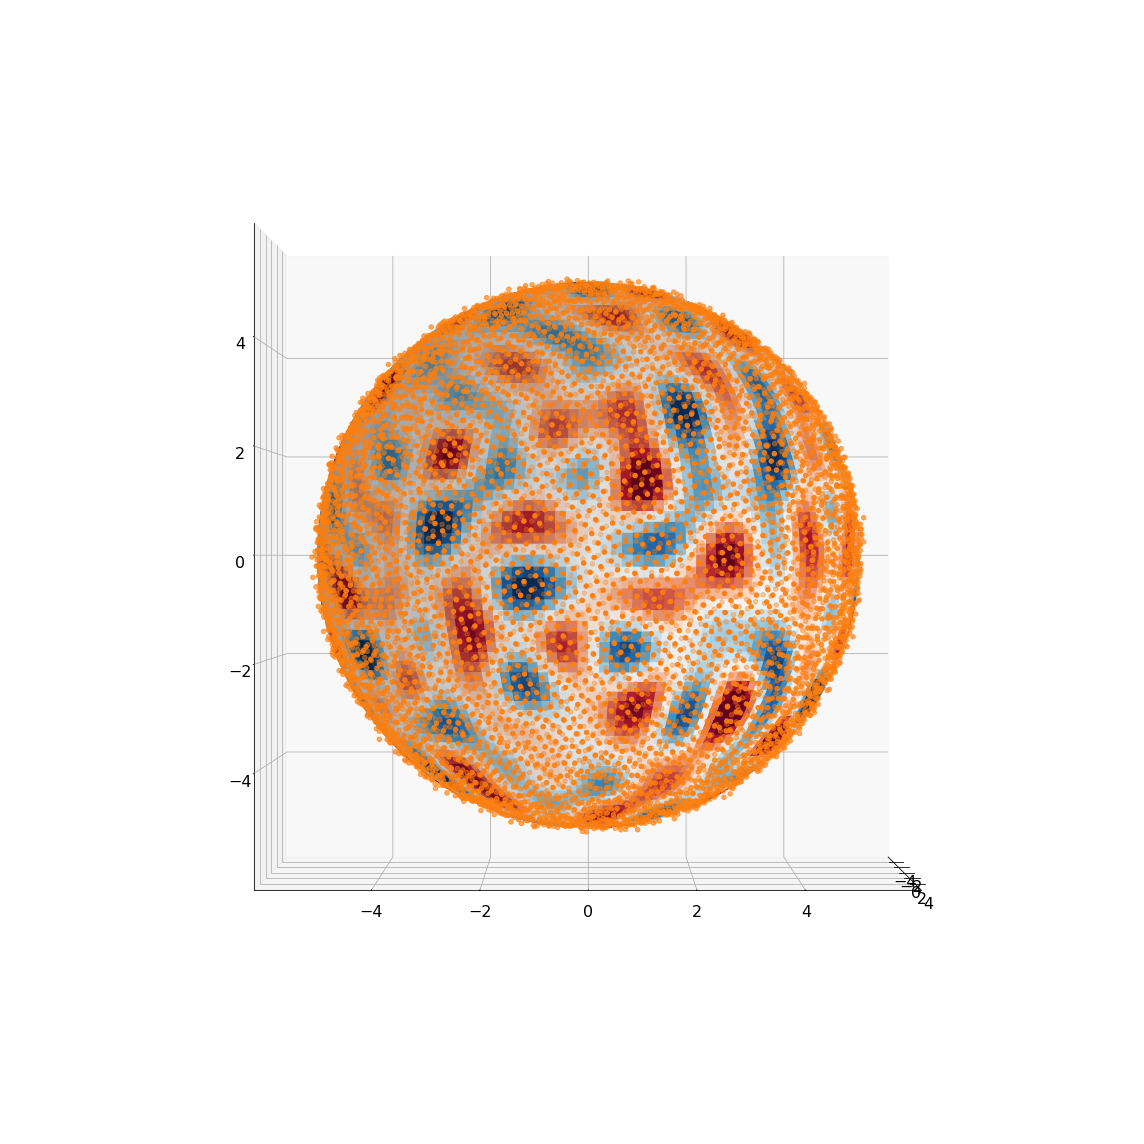

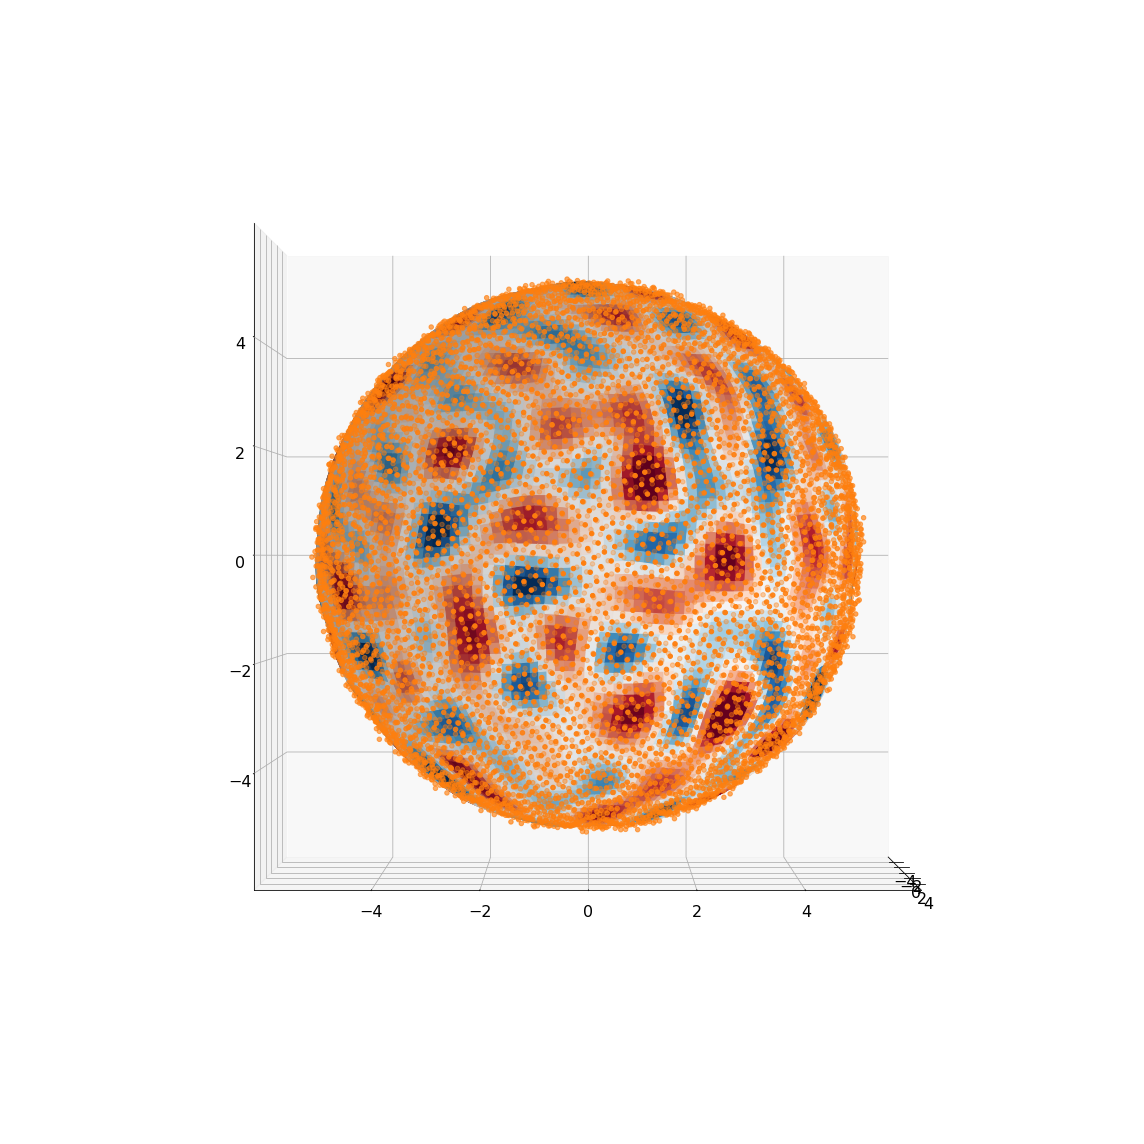

In [56]:
umesh = visSHVec(Uvecmin, lmax_plot=80, lonshift=180, 
                 n_vrange=(-0.1,0.1), SphCoord=False, Complex=True, 
                 config_quiver=(2,4,'k', 10), mesh=True)#+u0
fig, ax = visSH3d(umesh*0, cmesh=tmesh, r0=r0, show=False, elevation=0)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')
plt.tight_layout()
#fig.savefig(shapename+'_3dshape_original.png', transparent=True)
fig, ax = visSH3d(umesh, cmesh=tmesh, r0=r0, show=False, elevation=0)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')
plt.tight_layout()
#fig.savefig(shapename+'_3dshape.png', transparent=True)

plt.show()

In [2]:
print(0.012310460488181475*5.26)

0.06475302216783456
